## README

- Data: https://www.kaggle.com/competitions/titanic/data
- My GitHub with markdown notes: [fastai/course22/05-linear-model-and-neural-net-from-scratch.ipynb](https://github.com/prasanth-ntu/fastai-course22/blob/master/05-linear-model-and-neural-net-from-scratch.ipynb)


## Introduction

In [1]:
import os
from pathlib import Path
import zipfile, kaggle

import torch, numpy as np, pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from torch import tensor
import torch.nn.functional as F

from fastai.data.transforms import RandomSplitter

In [ ]:
from fastai.data.transforms import RandomSpliddtter


In [3]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('../input/titanic')
else:
    competition_name = 'titanic'
    path = Path(f'../{competition_name}')
    if not path.exists():
        kaggle.api.competition_download_cli(competition=competition_name, path = '../')
        zipfile.ZipFile(f'{path}.zip').extractall(path)
    else:
        print (f"path: '{path}' exists")
print (f"Files: {os.listdir(path)}")

path: '../titanic' exists
Files: ['test.csv', 'train.csv', 'gender_submission.csv']


In [4]:
print (f"Default | numpy > printoptions > linewidth: {np.get_printoptions()['linewidth']}")
print (f"Default | pandas > display.width: {pd.get_option('display.width')}")
print (f"Default | pytorch > printoptions > linewidth: {80}")

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

Default | numpy > printoptions > linewidth: 75
Default | pandas > display.width: 80
Default | pytorch > printoptions > linewidth: 80


## Cleaning the data

In [5]:
df = pd.read_csv(f"{path}/train.csv")
print (df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# check for missing values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# Replace missing values by using mode!
# Note: There are better approaches, but let's keep it simple for start
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [8]:
df.fillna(value=modes, inplace=True)

In [9]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [10]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [12]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype='object')

In [13]:
# Let's preprocess the following features
['Age', 'SibSp', 'Parch'] # Continuous: No processing (as SibSp and Parch are ordinal)
['Fare'] # Continuous: Fix long tail data distribution issue
['Pclass', 'Sex', 'Embarked'] # Categorial: Generate dummy variables (as they are categorical) for nominal

['Pclass', 'Sex', 'Embarked']

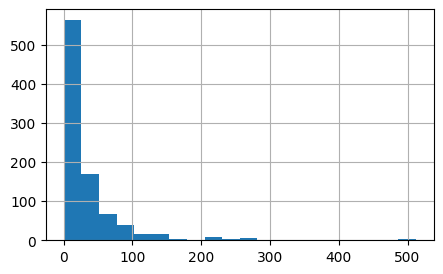

In [14]:
df['Fare'].hist(figsize=(5,3), bins=20);

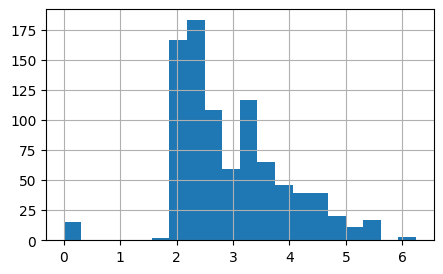

In [15]:
# Taking log to solve the skewness in the data to make it more uniformly distributed
df['LogFare'] = np.log(df['Fare']+1) # +1 to handle log(0) error as some Fare values are 0.
df['LogFare'].hist(figsize=(5,3), bins=20);

The 3 'Pclass' are [1, 2, 3]


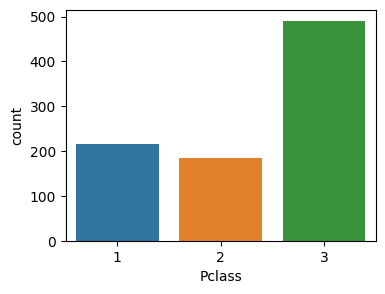

In [16]:
pclasses = sorted(df['Pclass'].unique())
print (f"The {len(pclasses)} 'Pclass' are {pclasses}")
plt.figure(figsize=(4,3))
sns.countplot(df, x='Pclass');

The 3 'Embarked' places are ['C', 'Q', 'S']


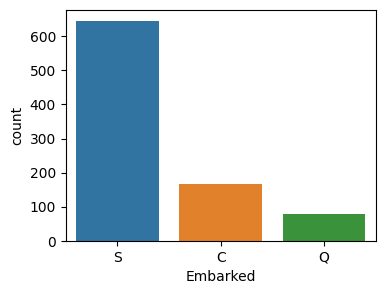

In [17]:
embarked_places = sorted(df['Embarked'].unique())
print (f"The {len(embarked_places)} 'Embarked' places are {embarked_places}")
plt.figure(figsize=(4,3))
sns.countplot(df, x='Embarked');

The 'Sex' vlaues are ['male' 'female']


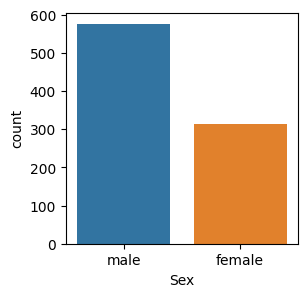

In [18]:
print (f"The 'Sex' vlaues are {df['Sex'].unique()}")
plt.figure(figsize=(3,3))
sns.countplot(df, x='Sex');

In [19]:
# Add dummy variables as additional cols
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [20]:
added_cols = ['Sex_male', 'Sex_female',
              'Pclass_1', 'Pclass_2', 'Pclass_3', 
              'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head(2)

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False


In [21]:
# Create dependent variable as Rank 1 Tensor
t_dep = tensor(df['Survived'])
print (f"Shape: {t_dep.shape}") # 1D data
print (f"Rank : {len(t_dep.shape)}")
print (t_dep[:10])

Shape: torch.Size([891])
Rank : 1
tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])


In [22]:
# Create dependent variables as a Rank 2 Tensor
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values.astype(float), dtype=torch.float) # torch.float == torch.float32
print (f"Shape: {t_indep.shape}") # 2D data
print (f"Rank : {len(t_indep.shape)}")
print (t_indep[:2])

Shape: torch.Size([891, 12])
Rank : 2
tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000]])


## Setting up a linear model

In [68]:
torch.manual_seed(442)

# Create initial coefficients for our linear model
n_coeffs = t_indep.shape[1]
coeffs = torch.rand(n_coeffs) - 0.5
print (f"{coeffs.shape}")
coeffs

torch.Size([12])


tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [69]:
# y_pred = w1x1 + w2x2 + ... + wnxn
# Lets compute the [w1x1 w2x2 ... wnxn] as a matrix
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [70]:
# Problem: Since some feature cols (esp. Age) are of high magnitude, they would dominate the other cols
# Solution: Divide all the feature cols by their max (primitive approach), so max value will be 1

vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals # (Auto-) Broadcasting vector into matrix for division across all rows

In [71]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [72]:
preds = (t_indep*coeffs).sum(dim=1)
print (preds.shape)
preds[:10]

torch.Size([891])


tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [73]:
# define loss function as MAE (to do gradient descent to optimize weights, we need loss function)
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5382)

In [74]:
def calc_preds(coeffs, indeps):
    preds = (indeps*coeffs).sum(axis=1)
    return preds

def cal_loss(coeffs, indeps, deps):
    preds = calc_preds(coeffs, indeps)
    loss = torch.abs(preds - deps).mean()
    return loss

## Doing a gradient descent step

In [75]:
# Enable tracking in computational graph (so that PyTorch compute gradients during backprop)
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [76]:
# Calculate loss (and PyTorch will keep track of all the steps so that PyTorch compute gradients during backprop)
loss = cal_loss(coeffs=coeffs, indeps=t_indep, deps=t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [77]:
loss.backward()

In [78]:
# A negative grad implies that the coefficient needs to be increased and viceversa
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [79]:
# Each time when we call loss.backward(), the gradients are added to coeffs.grad attribute value
loss = cal_loss(coeffs=coeffs, indeps=t_indep, deps=t_dep)
print (loss)
loss.backward()
coeffs.grad 

tensor(0.5382, grad_fn=<MeanBackward0>)


tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

In [80]:
# So, we need to set the coeffs.grad after using the gradients to do a gradient descent step

In [81]:
# Let's do one gradient step and see whether the loss decreases

coeffs.grad.zero_()
loss = cal_loss(coeffs=coeffs, indeps=t_indep, deps=t_dep)
loss.backward()

with torch.no_grad(): # disabled gradient calculation
    coeffs = coeffs.sub_(other=0.1 * coeffs.grad) # coeff = coeff - learning_rate*gradient
    coeffs.grad.zero_()
    loss = cal_loss(coeffs=coeffs, indeps=t_indep, deps=t_dep)    
    print (loss)

tensor(0.5197)


In [ ]:
# The loss value has decreased from 0.5382 to 0.5197 after one gradient descent step

## Training the linear model

In [86]:
# Split data into train and valid sets

# Get indices for trn and val split
trn_split_indices, val_split_indices = RandomSplitter(seed=42)(df)
print (len(trn_split_indices), len(val_split_indices))
print (trn_split_indices[:5], val_split_indices[:5])

713 178
[788, 525, 821, 253, 374] [303, 778, 531, 385, 134]


In [88]:
# apply the indices to our indep and dep var
trn_indep, val_indep = t_indep[trn_split_indices], t_indep[val_split_indices]
trn_dep, val_dep = t_dep[trn_split_indices], t_dep[val_split_indices]
print (len(trn_indep), len(val_indep))

713 178


In [110]:
# create fns for updating coeffs, doing one full grad desc step, and init coefs
def init_coeffs(n_coeffs):
    coeffs = torch.rand(n_coeffs) - 0.5
    coeffs.requires_grad_()
    return coeffs

def update_coeffs(coeffs, lr):
    coeffs.sub_(lr*coeffs.grad)
    return coeffs.grad.zero_()
    
def one_epoch(coeffs, lr, indeps, deps):
    loss = cal_loss(coeffs, indeps, deps)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    return coeffs, loss

In [133]:
def train_model(n_coeffs, indeps, deps, epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs(n_coeffs)
    for i in range(epochs):
        coeffs, loss = one_epoch(coeffs, lr, indeps, deps)
        # Print loss after every gradient descent update step for each epoch
        print (f"i={i:>3d} | loss={loss:>5.3f}")
    return coeffs

In [134]:
# Loss should decrease after every epoch
coeffs = train_model(n_coeffs=n_coeffs, indeps=trn_indep, deps=trn_dep, epochs=18, lr=0.2)

i=  0 | loss=0.536
i=  1 | loss=0.502
i=  2 | loss=0.477
i=  3 | loss=0.454
i=  4 | loss=0.431
i=  5 | loss=0.409
i=  6 | loss=0.388
i=  7 | loss=0.367
i=  8 | loss=0.349
i=  9 | loss=0.336
i= 10 | loss=0.330
i= 11 | loss=0.326
i= 12 | loss=0.329
i= 13 | loss=0.304
i= 14 | loss=0.314
i= 15 | loss=0.296
i= 16 | loss=0.300
i= 17 | loss=0.289


In [138]:
coeffs

tensor([-0.2694,  0.0901,  0.2359,  0.0280, -0.3990,  0.2345,  0.7232,  0.4112,  0.3601,  0.0955,  0.2395,  0.2122], requires_grad=True)

In [165]:
# Turn off requires_grad_ to False as training is completed, and we will only do inference
coeffs.requires_grad_(False)

tensor([-0.2694,  0.0901,  0.2359,  0.0280, -0.3990,  0.2345,  0.7232,  0.4112,  0.3601,  0.0955,  0.2395,  0.2122])

In [170]:
def show_coeffs(coeffs, indep_cols):
    return dict(zip(indep_cols, coeffs.numpy()))
show_coeffs(coeffs, indep_cols)

{'Age': -0.26935664,
 'SibSp': 0.090121895,
 'Parch': 0.2359452,
 'LogFare': 0.027992353,
 'Sex_male': -0.3990123,
 'Sex_female': 0.2345131,
 'Pclass_1': 0.7232336,
 'Pclass_2': 0.4111845,
 'Pclass_3': 0.36010766,
 'Embarked_C': 0.09548305,
 'Embarked_Q': 0.23946138,
 'Embarked_S': 0.2121628}

## Measuring accuracy